## Overview 
This chapter continues the introduction to predictive modelling through
classification. While the previous chapter covered training and data
preprocessing, this chapter focuses on how to split data, how to evaluate
prediction accuracy, and how to choose model parameters to maximize
performance.

## Chapter learning objectives 
By the end of the chapter, students will be able to:

- Describe what training, validation, and test data sets are and how they are used in classification
- Split data into training, validation, and test data sets
- Evaluate classification accuracy in R using a validation data set and appropriate metrics
- Execute cross-validation in R to choose the number of neighbours in a K-nearest neighbour classifier
- Describe advantages and disadvantages of the K-nearest neighbour classification algorithm


## Evaluating accuracy

Sometimes our classifier might make the wrong prediction. A classifier does not
need to be right 100\% of the time to be useful, though we don't want the
classifier to make too many wrong predictions. How do we measure how "good" our
classifier is? Let's revisit the 
[breast cancer images example](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)
and think about how our classifier will be used in practice. A biopsy will be
performed on a *new* patient's tumour, the resulting image will be analyzed,
and the classifier will be asked to decide whether the tumour is benign or
malignant. The key word here is *new*: our classifier is "good" if it provides
accurate predictions on data *not seen during training*. But then how can we
evaluate our classifier without having to visit the hospital to collect more
tumour images? 

The trick is to split up the data set into a **training set** and **test set**,
and only show the classifier the **training set** when building the classifier.
Then to evaluate the accuracy of the classifier, we can use it to predict the
labels (which we know) in the **test set**. If our predictions match the true
labels for the observations in the **test set** very well, then we have some
confidence that our classifier might also do a good job of predicting the class
labels for new observations that we do not have the class labels for.

How exactly can we assess how well our predictions match the true labels for
the observations in the test set? One way we can do this is to calculate the
**prediction accuracy**. This is the fraction of examples for which the
classiier made the correct prediction. To calculate this we divide the number
of correct predictions by the number of predictions made. Other measures for
how well our classifier performed include *precision* and *recall*; these will
not be discussed here, but you will encounter them in other more advanced
courses on this topic.

In R, we can use the `tidymodels` library collection not only to perform K-nearest neighbour
classification, but also to assess how well our classification worked. Let's
start by loading the necessary libraries, reading in the breast cancer data
from the previous chapter, and making a quick scatter plot visualization of
tumour cell concavity versus smoothness coloured by diagnosis.


Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::

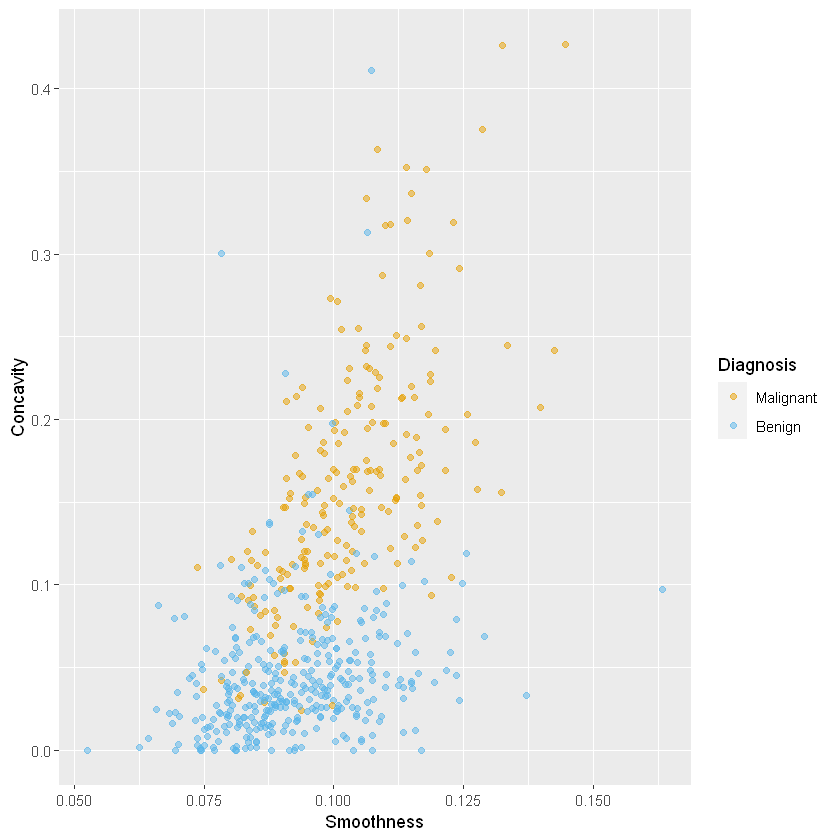

In [1]:
# load packages
library(tidyverse)
library(tidymodels)
# load data
cancer <- read_csv("unscaled_wdbc.csv") %>%
  mutate(Class = as_factor(Class)) # convert the character Class variable to the factor datatype
# colour palette
cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")
# create scatter plot of tumour cell concavity versus smoothness,
# labelling the points be diagnosis class
perim_concav <- cancer %>%
  ggplot(aes(x = Smoothness, y = Concavity, color = Class)) +
  geom_point(alpha = 0.5) +
  labs(color = "Diagnosis") +
  scale_color_manual(labels = c("Malignant", "Benign"), values = cbPalette)
perim_concav

**Create the train / test split**

Once we have decided on a predictive question to answer and done some
preliminary exploration, the very next thing to do is to split the data into
the training and test sets. Typically, the training set is between 50 - 100% of
the data, while the test set is the remaining 0 - 50%; the intuition is that
you want to trade off between training an accurate model (by using a larger
training data set) and getting an accurate evaluation of its performance (by
using a larger test data set).  Here, we will use 75% of the data for training,
and 25% for testing.  To do this we will use the `initial_split` function, 
specifying that `prop = 0.75` and the target variable is `Class`:

In [2]:
cancer_split <- initial_split(cancer, prop = 0.75, strata = Class)
cancer_train <- training(cancer_split)
cancer_test <- testing(cancer_split)

In [3]:
glimpse(cancer_train)
glimpse(cancer_test)

Rows: 427
Columns: 12
$ ID                <dbl> 842302, 84348301, 84358402, 843786, 84458202, 845...
$ Class             <fct> M, M, M, M, M, M, M, M, M, M, M, M, B, B, M, M, M...
$ Radius            <dbl> 17.99, 11.42, 20.29, 12.45, 13.71, 12.46, 19.17, ...
$ Texture           <dbl> 10.38, 20.38, 14.34, 15.70, 20.83, 24.04, 24.80, ...
$ Perimeter         <dbl> 122.80, 77.58, 135.10, 82.57, 90.20, 83.97, 132.4...
$ Area              <dbl> 1001.0, 386.1, 1297.0, 477.1, 577.9, 475.9, 1123....
$ Smoothness        <dbl> 0.11840, 0.14250, 0.10030, 0.12780, 0.11890, 0.11...
$ Compactness       <dbl> 0.27760, 0.28390, 0.13280, 0.17000, 0.16450, 0.23...
$ Concavity         <dbl> 0.30010, 0.24140, 0.19800, 0.15780, 0.09366, 0.22...
$ Concave_Points    <dbl> 0.14710, 0.10520, 0.10430, 0.08089, 0.05985, 0.08...
$ Symmetry          <dbl> 0.2419, 0.2597, 0.1809, 0.2087, 0.2196, 0.2030, 0...
$ Fractal_Dimension <dbl> 0.07871, 0.09744, 0.05883, 0.07613, 0.07451, 0.08...
Rows: 142
Columns: 12
$ ID    

We can see from `glimpse` in the code above that the training set contains 427
observations, while the test set contains 142 observations. This corresponds to
a train / test split of 75% / 25%, as desired.

**Pre-process the data**

As we mentioned last chapter, K-NN is sensitive to the scale of the predictors,
and so we should perform some preprocessing to standardize them. An
additional consideration we need to take when doing this is that we should
create the standardization preprocessor using **only the training data**. This ensures that
our test data does not influence any aspect of our model training. Once we have
created the standardization preprocessor, we can then apply it separately to both the
training and test data sets.

Fortunately, the `recipe` framework from `tidymodels` makes it simple to handle
this properly. Below we construct and prepare the recipe using only the training
data (due to `data = cancer_train` in the first line).

In [4]:
cancer_recipe <- recipe(Class ~ Smoothness + Concavity, data = cancer_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

**Train the classifier**

Now that we have split our original data set into training and test sets, we
can create our K-nearest neighbour classifier with only the training set using
the technique we learned in the previous chapter. For now, we will just choose
the number $K$ of neighbours to be 3, and use concavity and smoothness as the
predictors.

In [6]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_fit <- workflow() %>%
  add_recipe(cancer_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = cancer_train)
knn_fit

== Workflow [trained] ==================================================================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor --------------------------------------------------------------------------------------------------------
2 Recipe Steps

* step_scale()
* step_center()

-- Model ---------------------------------------------------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.09601874
Best kernel: rectangular
Best k: 3

**Predict the labels in the test set**

Now that we have a K-nearest neighbour classifier object, we can use it to
predict the class labels for our test set.  We use the `bind_cols` to add the
column of predictions to the original test data, creating the
`cancer_test_predictions` data frame.  The `Class` variable contains the true
diagnoses, while the `.pred_class` contains the predicted diagnoses from the
model.

In [8]:
cancer_test_predictions <- predict(knn_fit, cancer_test) %>%
  bind_cols(cancer_test)
cancer_test_predictions

.pred_class ID        Class Radius Texture Perimeter Area   Smoothness
1   M             842517  M     20.570 17.77   132.90    1326.0 0.08474   
2   M           84300903  M     19.690 21.25   130.00    1203.0 0.10960   
3   M             844359  M     18.250 19.98   119.60    1040.0 0.09463   
4   M             844981  M     13.000 21.82    87.50     519.8 0.12730   
5   B             845636  M     16.020 23.24   102.70     797.8 0.08206   
6   M           84610002  M     15.780 17.89   103.60     781.0 0.09710   
7   B             848406  M     14.680 20.13    94.74     684.5 0.09867   
8   B            8510824  B      9.504 12.44    60.34     273.9 0.10240   
9   B             854941  B     13.030 18.42    82.61     523.8 0.08983   
10  B             855133  M     14.990 25.20    95.54     698.8 0.09387   
11  B             855563  M     10.950 21.35    71.90     371.1 0.12270   
12  M             855625  M     19.070 24.81   128.30    1104.0 0.09081   
13  M             856106  M     13.280 20.28    87.32     545.2 0.10410   
14  M             857010  M     18.650 17.60   123.70    1076.0 0.10990   
15  B             857343  B     11.760 21.60    74.72     427.9 0.08637   
16  B             857374  B     11.940 18.24    75.71     437.6 0.08261   
17  B             858970  B     10.170 14.88    64.55     311.9 0.11340   
18  M           85922302  M     12.680 23.84    82.69     499.0 0.11220   
19  B             859464  B      9.465 21.01    60.11     269.4 0.10440   
20  M             859711  B      8.888 14.64    58.79     244.0 0.09783   
21  B             859983  M     13.800 15.79    90.43     584.1 0.10070   
22  M            8610637  M     18.050 16.15   120.20    1006.0 0.10650   
23  B            8610908  B     12.860 18.00    83.19     506.3 0.09934   
24  M            8611555  M     25.220 24.91   171.50    1878.0 0.10630   
25  M            8612399  M     18.460 18.52   121.10    1075.0 0.09874   
26  M             861598  B     14.640 15.24    95.77     651.9 0.11320   
27  M             862028  M     15.060 19.83   100.30     705.6 0.10390   
28  B             864033  B      9.777 16.99    62.50     290.2 0.10370   
29  M              86409  B     14.260 19.65    97.83     629.9 0.07837   
30  M             864726  B      8.950 15.76    58.74     245.2 0.09462   
... ...         ...       ...   ...    ...     ...       ...    ...       
113 M             9110127 M     18.030 16.85   117.50     990.0 0.08947   
114 B             9110720 B     11.990 24.89    77.61     441.3 0.10300   
115 B           911157302 M     21.100 20.52   138.10    1384.0 0.09684   
116 B             9112366 B     11.630 29.29    74.87     415.1 0.09357   
117 B             9112594 B     13.000 25.13    82.61     520.2 0.08369   
118 B             9112712 B      9.755 28.20    61.68     290.9 0.07984   
119 B           911320501 B     11.600 18.36    73.88     412.7 0.08508   
120 B             9113239 B     13.240 20.13    86.87     542.9 0.08284   
121 B             9113455 B     13.140 20.74    85.98     536.9 0.08675   
122 M              911366 B     11.620 18.18    76.38     408.8 0.11750   
123 B              911384 B     14.920 14.93    96.45     686.9 0.08098   
124 B              914101 B     12.460 12.83    78.83     477.3 0.07372   
125 B              914580 B     12.470 17.31    80.45     480.1 0.08928   
126 B               91505 B     12.540 16.32    81.25     476.3 0.11580   
127 M              915143 M     23.090 19.83   152.10    1682.0 0.09342   
128 M              915460 M     15.460 23.95   103.80     731.3 0.11830   
129 B              915940 B     14.580 13.66    94.29     658.8 0.09832   
130 B              917092 B      9.295 13.90    59.96     257.8 0.13710   
131 B            91813701 B     13.460 18.75    87.44     551.1 0.10750   
132 B               91858 B     11.750 17.56    75.89     422.9 0.10730   
133 M            91979701 M     14.270 22.55    93.77     629.8 0.10380   
134 B              921386 B  

**Compute the accuracy**

Finally we can assess our classifier's accuracy. To do this we use the `metrics` function
from `tidymodels` to get the statistics about the quality of our model, specifying
the `truth` and `estimate` arguments:


In [9]:
cancer_test_predictions %>%
  metrics(truth = Class, estimate = .pred_class)

.metric  .estimator .estimate
1 accuracy binary     0.8239437
2 kap      binary     0.6222601

This shows that the accuracy of the classifier on the test data was 88%.
We can also look at the *confusion matrix* for the classifier, which shows
the table of predicted labels and correct labels, using the `conf_mat` function:

In [10]:
cancer_test_predictions %>%
  conf_mat(truth = Class, estimate = .pred_class)

          Truth
Prediction  M  B
         M 40 12
         B 13 77

This says that the classifier labelled 43+82 = 125 observations correctly,
 10 observations as benign when they were truly malignant,
and 7 observations as malignant when they were truly benign. 

## Tuning the classifier

The vast majority of predictive models in statistics and machine learning have
*parameters* that you have to pick. For example, in the K-nearest neighbour
classification algorithm we have been using in the past two chapters, we have
had to pick the number of neighbours $K$ for the class vote. Is it possible to
make this selection, i.e., *tune* the model, in a principled way?  Ideally what
we want is to somehow maximize the performance of our classifier on data *it
hasn't seen yet*. So we will play the same trick we did before when evaluating
our classifier: we'll split our **overall training data set** further into two
subsets, called the **training set** and **validation set**. We will use the
newly-named **training set** for building the classifier, and the **validation
set** for evaluating it! Then we will try different values of the parameter $K$
and pick the one that yields the highest accuracy.

### Cross-validation

There is an important detail to mention about the process of tuning: we can, if
we want to, split our overall training data up in multiple different ways,
train and evaluate a classifier for each split, and then choose the parameter
based on __*all*__ of the different results. If we just split our overall training
data *once*, our best parameter choice will depend strongly on whatever data
was lucky enough to end up in the validation set. Perhaps using multiple
different train / validation splits, we'll get a better estimate of accuracy,
which will lead to a better choice of the number of neighbours $K$ for the
overall set of training data. 

> **Note:** you might be wondering why we can't we use the multiple splits to test our final classifier after tuning is done. This is simply
> because at the end of the day, we will produce a single classifier using our overall training data. If we do multiple train / test splits, we will
> end up with multiple classifiers, each with their own accuracy evaluated on different test data.
Let's investigate this idea in R! In particular, we will use different seed
values in the `set.seed` function to generate five different train / validation
splits of our overall training data, train five different K-nearest neighbour
models, and evaluate their accuracy. 

In [11]:
accuracies <- c()
for (i in 1:5) {
  set.seed(i) # makes the random selection of rows reproducible
  # create the 25/75 split of the training data into training and validation
  cancer_split <- initial_split(cancer_train, prop = 0.75, strata = Class)
  cancer_subtrain <- training(cancer_split)
  cancer_validation <- testing(cancer_split)
  # recreate the standardization recipe from before (since it must be based on the training data)
  cancer_recipe <- recipe(Class ~ Smoothness + Concavity, data = cancer_subtrain) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
  # fit the knn model (we can reuse the old knn_spec model from before)
  knn_fit <- workflow() %>%
    add_recipe(cancer_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = cancer_subtrain)
  # get predictions on the validation data
  validation_predicted <- predict(knn_fit, cancer_validation) %>%
    bind_cols(cancer_validation)
  # compute the accuracy
  acc <- validation_predicted %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
  accuracies <- append(accuracies, acc)
}
accuracies

[1] 0.8867925 0.9056604 0.8962264 0.8679245 0.9056604

With five different shuffles of the data, we get five different values for
accuracy. None of these is necessarily "more correct" than any other; they're
just five estimates of the true, underlying accuracy of our classifier built
using our overall training data. We can combine the estimates by taking their
average (here `r mean(accuracies)`) to try to get a single assessment of our
classifier's accuracy; this has the effect of reducing the influence of any one
(un)lucky validation set on the estimate.

In practice, we don't use random splits, but rather use a more structured
splitting procedure so that each observation in the data set is used in a
validation set only a single time. The name for this strategy is called
**cross-validation**.  In **cross-validation**, we split our **overall training
data** into $C$ evenly-sized chunks, and then iteratively use $1$ chunk as the
**validation set** and combine the remaining $C-1$ chunks 
as the **training set**:

 To do 5-fold cross-validation in R with `tidymodels`, we
use another function: `vfold_cv`. This function splits our training data into
`v` folds automatically:

In [12]:
cancer_vfold <- vfold_cv(cancer_train, v = 5, strata = Class)
cancer_vfold

splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Then, when we create our data analysis workflow, we use the `fit_resamples` function
instead of the `fit` function for training. This runs cross-validation on each
train/validation split. 

> **Note:** we set the seed when we call `train` not only because of the potential for ties, but also because we are doing 
> cross-validation. Cross-validation uses a random process to select how to partition the training data.

In [13]:
set.seed(1)
# recreate the standardization recipe from before (since it must be based on the training data)
cancer_recipe <- recipe(Class ~ Smoothness + Concavity, data = cancer_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() %>%
  add_recipe(cancer_recipe) %>%
  add_model(knn_spec) %>%
  fit_resamples(resamples = cancer_vfold)
knn_fit

Warning message:
"package 'rlang' was built under R version 3.6.3"
Attaching package: 'rlang'

The following objects are masked from 'package:purrr':

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice

Warning message:
"package 'vctrs' was built under R version 3.6.3"
Attaching package: 'vctrs'

The following object is masked from 'package:dplyr':

    data_frame

The following object is masked from 'package:tibble':

    data_frame

Warning message:
"package 'kknn' was built under R version 3.6.3"

splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

The `collect_metrics` function is used to aggregate the mean and *standard error*
of the classifier's validation accuracy across the folds. The standard error is 
a measure of how uncertain we are in the mean value. A detailed treatment of this
is beyond the scope of this chapter; but roughly, if your estimated mean (that
the `collect_metrics` function gives you) is 0.88 and standard
error is 0.02, you can expect the *true* average accuracy of the 
classifier to be somewhere roughly between 0.86 and 0.90 (although it may
fall outside this range).

In [14]:
knn_fit %>% collect_metrics()


.metric  .estimator mean      n std_err     .config             
1 accuracy binary     0.8968738 5 0.009626469 Preprocessor1_Model1
2 roc_auc  binary     0.9344315 5 0.004605009 Preprocessor1_Model1

We can choose any number of folds, and typically the more we use the better our
accuracy estimate will be (lower standard error). However, we are limited 
by computational power: the
more folds we choose, the  more computation it takes, and hence the more time
it takes to run the analysis. So when you do cross-validation, you need to
consider the size of the data, and the speed of the algorithm (e.g., K-nearest
neighbour) and the speed of your computer. In practice, this is a trial and
error process, but typically $C$ is chosen to be either 5 or 10. Here we show
how the standard error decreases when we use 10-fold cross validation rather
than 5-fold:

In [15]:
cancer_vfold <- vfold_cv(cancer_train, v = 10, strata = Class)
workflow() %>%
  add_recipe(cancer_recipe) %>%
  add_model(knn_spec) %>%
  fit_resamples(resamples = cancer_vfold) %>%
  collect_metrics()

.metric  .estimator mean      n  std_err    .config             
1 accuracy binary     0.9043716 10 0.01307448 Preprocessor1_Model1
2 roc_auc  binary     0.9318803 10 0.01528273 Preprocessor1_Model1

### Parameter value selection

Using 5- and 10-fold cross-validation, we have estimated that the prediction
accuracy of our classifier is somewhere around 88%. Whether 88% is good or not
depends entirely on the downstream application of the data analysis. In the
present situation, we are trying to predict a tumour diagnosis, with expensive,
damaging chemo/radiation therapy or patient death as potential consequences of
misprediction. Hence, we'd like to do better than 88% for this application.  

In order to improve our classifier, we have one choice of parameter: the number of
neighbours, $K$. Since cross-validation helps us evaluate the accuracy of our
classifier, we can use cross-validation to calculate an accuracy for each value
of $K$ in a reasonable range, and then pick the value of $K$ that gives us the
best accuracy. The `tidymodels` package collection provides a very simple
syntax for tuning models: each parameter in the model to be tuned should be specified
as `tune()` in the model specification rather than given a particular value.

In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

Then instead of using `fit` or `fit_resamples`, we will use the `tune_grid` function
to fit the model for each value in a range of parameter values. Here the `grid = 10`
argument specifies that the tuning should try 10 values of the number of neighbours
$K$ when tuning. We set the seed prior to tuning to ensure results are reproducible:

In [17]:
set.seed(1)
knn_results <- workflow() %>%
  add_recipe(cancer_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = cancer_vfold, grid = 10) %>%
  collect_metrics()
knn_results

neighbors .metric  .estimator mean      n  std_err     .config              
1   2        accuracy binary     0.8762350 10 0.019211950 Preprocessor1_Model01
2   2        roc_auc  binary     0.9163070 10 0.012841254 Preprocessor1_Model01
3   3        accuracy binary     0.9043716 10 0.013074478 Preprocessor1_Model02
4   3        roc_auc  binary     0.9318803 10 0.015282728 Preprocessor1_Model02
5   5        accuracy binary     0.9043162 10 0.013993888 Preprocessor1_Model03
6   5        roc_auc  binary     0.9420548 10 0.010551548 Preprocessor1_Model03
7   6        accuracy binary     0.9043162 10 0.013993888 Preprocessor1_Model04
8   6        roc_auc  binary     0.9458440 10 0.009759303 Preprocessor1_Model04
9   7        accuracy binary     0.9114037 10 0.013683679 Preprocessor1_Model05
10  7        roc_auc  binary     0.9426024 10 0.010301873 Preprocessor1_Model05
11  9        accuracy binary     0.9114037 10 0.013237241 Preprocessor1_Model06
12  9        roc_auc  binary     0.9431989 10 0.009781066 Preprocessor1_Model06
13 10        accuracy binary     0.9114037 10 0.013237241 Preprocessor1_Model07
14 10        roc_auc  binary     0.9460069 10 0.009265707 Preprocessor1_Model07
15 12        accuracy binary     0.9090781 10 0.014797846 Preprocessor1_Model08
16 12        roc_auc  binary     0.9484117 10 0.008459217 Preprocessor1_Model08
17 13        accuracy binary     0.9090781 10 0.013524819 Preprocessor1_Model09
18 13        roc_auc  binary     0.9493207 10 0.007799441 Preprocessor1_Model09
19 15        accuracy binary     0.9044270 10 0.014377970 Preprocessor1_Model10
20 15        roc_auc  binary     0.9496626 10 0.007917207 Preprocessor1_Model10

We can select the best value of the number of neighbours (i.e., the one that results
in the highest classifier accuracy estimate) by plotting the accuracy versus $K$:

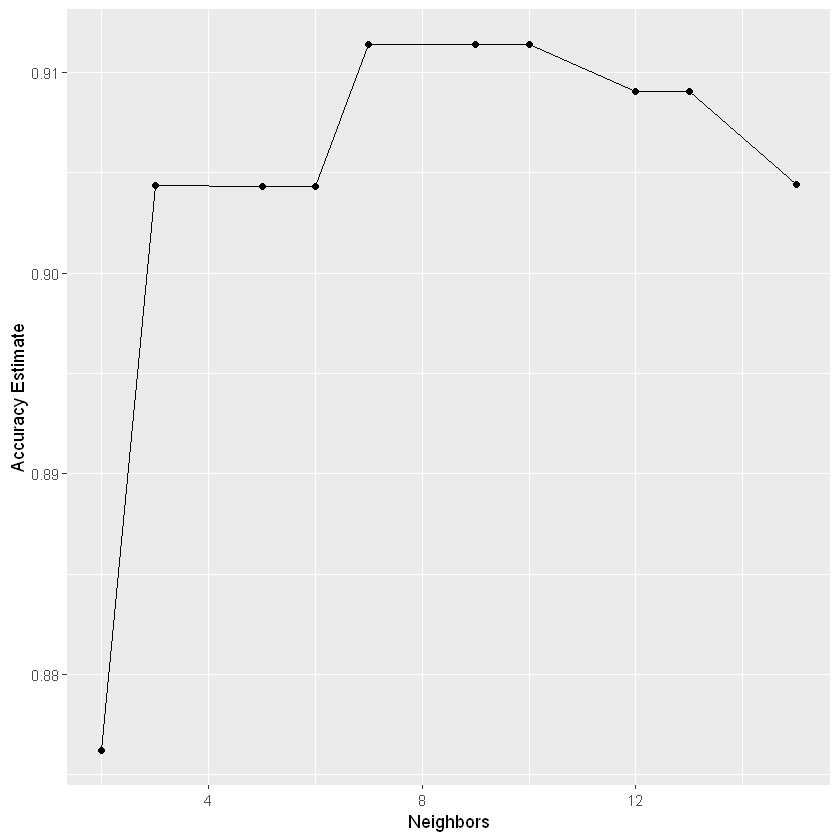

In [18]:
accuracies <- knn_results %>%
  filter(.metric == "accuracy")
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k

This visualization suggests that $K = 7$ provides the highest accuracy.
But as you can see, there is no exact or perfect answer here; 
 any selection between $K = 3$ and $13$ would be reasonably justified, as all
of these differ in classifier accuracy by less than 1%. Remember: the
values you see on this plot are *estimates* of the true accuracy of our
classifier. Although the $K=7$ value is higher than the others on this plot,
that doesn't mean the classifier is actually more accurate with this parameter
value! Generally, when selecting $K$ (and other parameters for other predictive
models), we are looking for a value where:

- we get roughly optimal accuracy, so that our model will likely be accurate
- changing the value to a nearby one (e.g. from $K=7$ to 6 or 8) doesn't decrease accuracy too much, so that our choice is reliable in the presence of uncertainty
- the cost of training the model is not prohibitive (e.g., in our situation, if $K$ is too large, predicting becomes expensive!)

### Under/overfitting

To build a bit more intuition, what happens if we keep increasing the number of neighbours $K$? In fact, the accuracy 
actually starts to decrease! Rather than setting `grid = 10` and letting `tidymodels` decide what values of $K$ to try,
let's specify the values explicitly by creating a data frame with a `neighbors` variable. 
Take a look as the plot below as we vary $K$ from 1 to almost the number of observations in the data set:


In [19]:
set.seed(1)
k_lots <- tibble(neighbors = seq(from = 1, to = 385, by = 10))
knn_results <- workflow() %>%
  add_recipe(cancer_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = cancer_vfold, grid = k_lots) %>%
  collect_metrics()
accuracies <- knn_results %>%
  filter(.metric == "accuracy")
accuracy_vs_k_lots <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k_lots

! Fold01: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold02: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold03: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold04: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold05: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold06: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold07: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold08: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...
! Fold09: preprocessor 1/1, model 1/1: 381 samples were requested but there were 3...


**Underfitting:** What is actually happening to our classifier that causes
this? As we increase the number of neighbours, more and more of the training
observations (and those that are farther and farther away from the point) get a
"say" in what the class of a new observation is. This causes a sort of
"averaging effect" to take place, making the boundary between where our
classifier would predict a tumour to be malignant versus benign to smooth out
and become *simpler.* If you take this to the extreme, setting $K$ to the total
training data set size, then the classifier will always predict the same label
regardless of what the new observation looks like. In general, if the model
*isn't influenced enough* by the training data, it is said to **underfit** the
data.

**Overfitting:** In contrast, when we decrease the number of neighbours, each
individual data point has a stronger and stronger vote regarding nearby points.
Since the data themselves are noisy, this causes a more "jagged" boundary
corresponding to a *less simple* model.  If you take this case to the extreme,
setting $K = 1$, then the classifier is essentially just matching each new
observation to its closest neighbour in the training data set. This is just as
problematic as the large $K$ case, because the classifier becomes unreliable on
new data: if we had a different training set, the predictions would be
completely different.  In general, if the model *is influenced too much* by the
training data, it is said to **overfit** the data.

You can see this effect in the plots below as we vary the number of neighbours $K$ in (1, 7, 20, 200):

Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



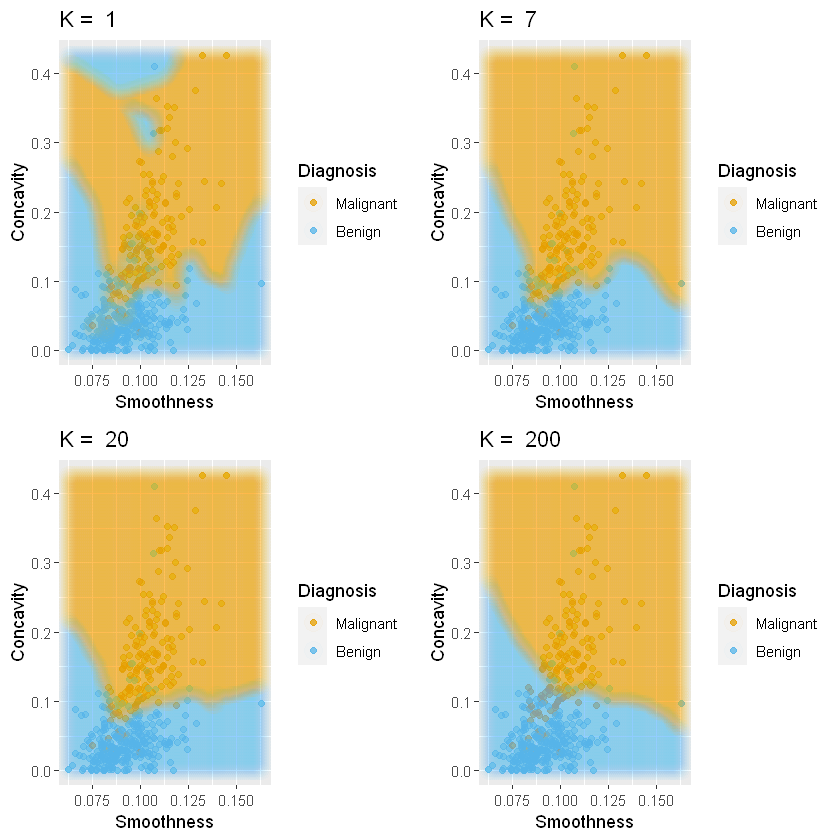

In [20]:
library(gridExtra)
ks <- c(1, 7, 20, 200)
plots <- list()
for (i in 1:length(ks)) {
  knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = ks[[i]]) %>%
    set_engine("kknn") %>%
    set_mode("classification")
  knn_fit <- workflow() %>%
    add_recipe(cancer_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = cancer_train)
  # create a prediction pt grid
  smo_grid <- seq(min(cancer_train$Smoothness), max(cancer_train$Smoothness), length.out = 100)
  con_grid <- seq(min(cancer_train$Concavity), max(cancer_train$Concavity), length.out = 100)
  scgrid <- as_tibble(expand.grid(Smoothness = smo_grid, Concavity = con_grid))
  knnPredGrid <- predict(knn_fit, scgrid)
  prediction_table <- bind_cols(knnPredGrid, scgrid) %>% rename(Class = .pred_class)
  # plot
  plots[[i]] <-
    ggplot() +
    geom_point(data = cancer_train, mapping = aes(x = Smoothness, y = Concavity, color = Class), alpha = 0.75) +
    geom_point(data = prediction_table, mapping = aes(x = Smoothness, y = Concavity, color = Class), alpha = 0.02, size = 5.) +
    labs(color = "Diagnosis") +
    ggtitle(paste("K = ", ks[[i]])) +
    scale_color_manual(labels = c("Malignant", "Benign"), values = cbPalette)
}
grid.arrange(grobs = plots)


## Splitting data

**Shuffling:** When we split the data into train, test, and validation sets, we
make the assumption that there is no order to our originally collected data
set. However, if we think that there might be some order to the original data
set, then we can randomly shuffle the data before splitting it. The `tidymodels`
function `initial_split` and `vfold_cv` functions do this for us. 

**Stratification:** If the data are imbalanced, we also need to be extra
careful about splitting the data to ensure that enough of each class ends up in
each of the train, validation, and test partitions. The `strata` argument
in the `initial_split` and `vfold_cv` functions handles this for us too. 

## Summary

Classification algorithms use one or more quantitative variables to predict the
value of a third, categorical variable. The K-nearest neighbour algorithm in
particular does this by first finding the K points in the training data nearest
to the new observation, and then returning the majority class vote from those
training observations. We can evaluate a classifier by splitting the data
randomly into a training and test data set, using the training set to build the
classifier, and using the test set to estimate its accuracy. To tune the
classifier (e.g., select the K in K-nearest neighbours), we maximize accuracy
estimates from cross-validation.
he overall workflow for performing K-nearest neighbour classification using `tidymodels` is as follows:

1. Use the `initial_split` function to split the data into a training and test set. Set the `strata` argument to the target variable. Put the test set aside for now.
2. Use the `vfold_cv` function to split up the training data for cross validation.
3. Create a `recipe` that specifies the target and predictor variables, as well as preprocessing steps for all variables. Pass the training data as the `data` argument of the recipe.
4. Create a `nearest_neighbors` model specification, with `neighbors = tune()`.
5. Add the recipe and model specification to a `workflow()`, and use the `tune_grid` function on the train/validation splits to estimate the classifier accuracy for a range of $K$ values.
6. Pick a value of $K$ that yields a high accuracy estimate that doesn't change much if you change $K$ to a nearby value.
7. Make a new model specification for the best parameter value, and retrain the classifier using the `fit` function.
8. Evaluate the estimated accuracy of the classifier on the test set using the `predict` function.

**Strengths:**

1. Simple and easy to understand
2. No assumptions about what the data must look like 
3. Works easily for binary (two-class) and multi-class (> 2 classes) classification problems

**Weaknesses:**

1. As data gets bigger and bigger, K-nearest neighbour gets slower and slower, quite quickly
2. Does not perform well with a large number of predictors
3. Does not perform well when classes are imbalanced (when many more observations are in one of the classes compared to the others)
